In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
import nltk

## Lectura de archivos

In [2]:
users_df = pd.read_csv(r"C:\Users\carlo\Downloads\users.csv", sep=",")
products_df = pd.read_csv(r"C:\Users\carlo\Downloads\products.csv", sep=";")
interactions_df = pd.read_csv(r"C:\Users\carlo\Downloads\interactions.csv", sep=",")

In [29]:
products_df = pd.read_csv(r"Datos\products.csv", sep=";")

## EDA

### Usuarios

In [3]:
print("El tamaño de la base de usuarios es:", users_df.shape)
print("Las columnas con las que cuenta es:", users_df.columns.tolist())
print("El número de ID's únicos es:", len(users_df['user_id'].unique()))

El tamaño de la base de usuarios es: (5000, 11)
Las columnas con las que cuenta es: ['user_id', 'edad', 'genero', 'nivel_ingresos', 'nivel_educativo', 'intereses', 'tipo_suscripcion', 'categoria_cliente', 'ubicacion', 'dispositivo', 'frecuencia_login']
El número de ID's únicos es: 5000


In [4]:
users_df.isna().sum()

user_id              0
edad                 0
genero               0
nivel_ingresos       0
nivel_educativo      0
intereses            0
tipo_suscripcion     0
categoria_cliente    0
ubicacion            0
dispositivo          0
frecuencia_login     0
dtype: int64

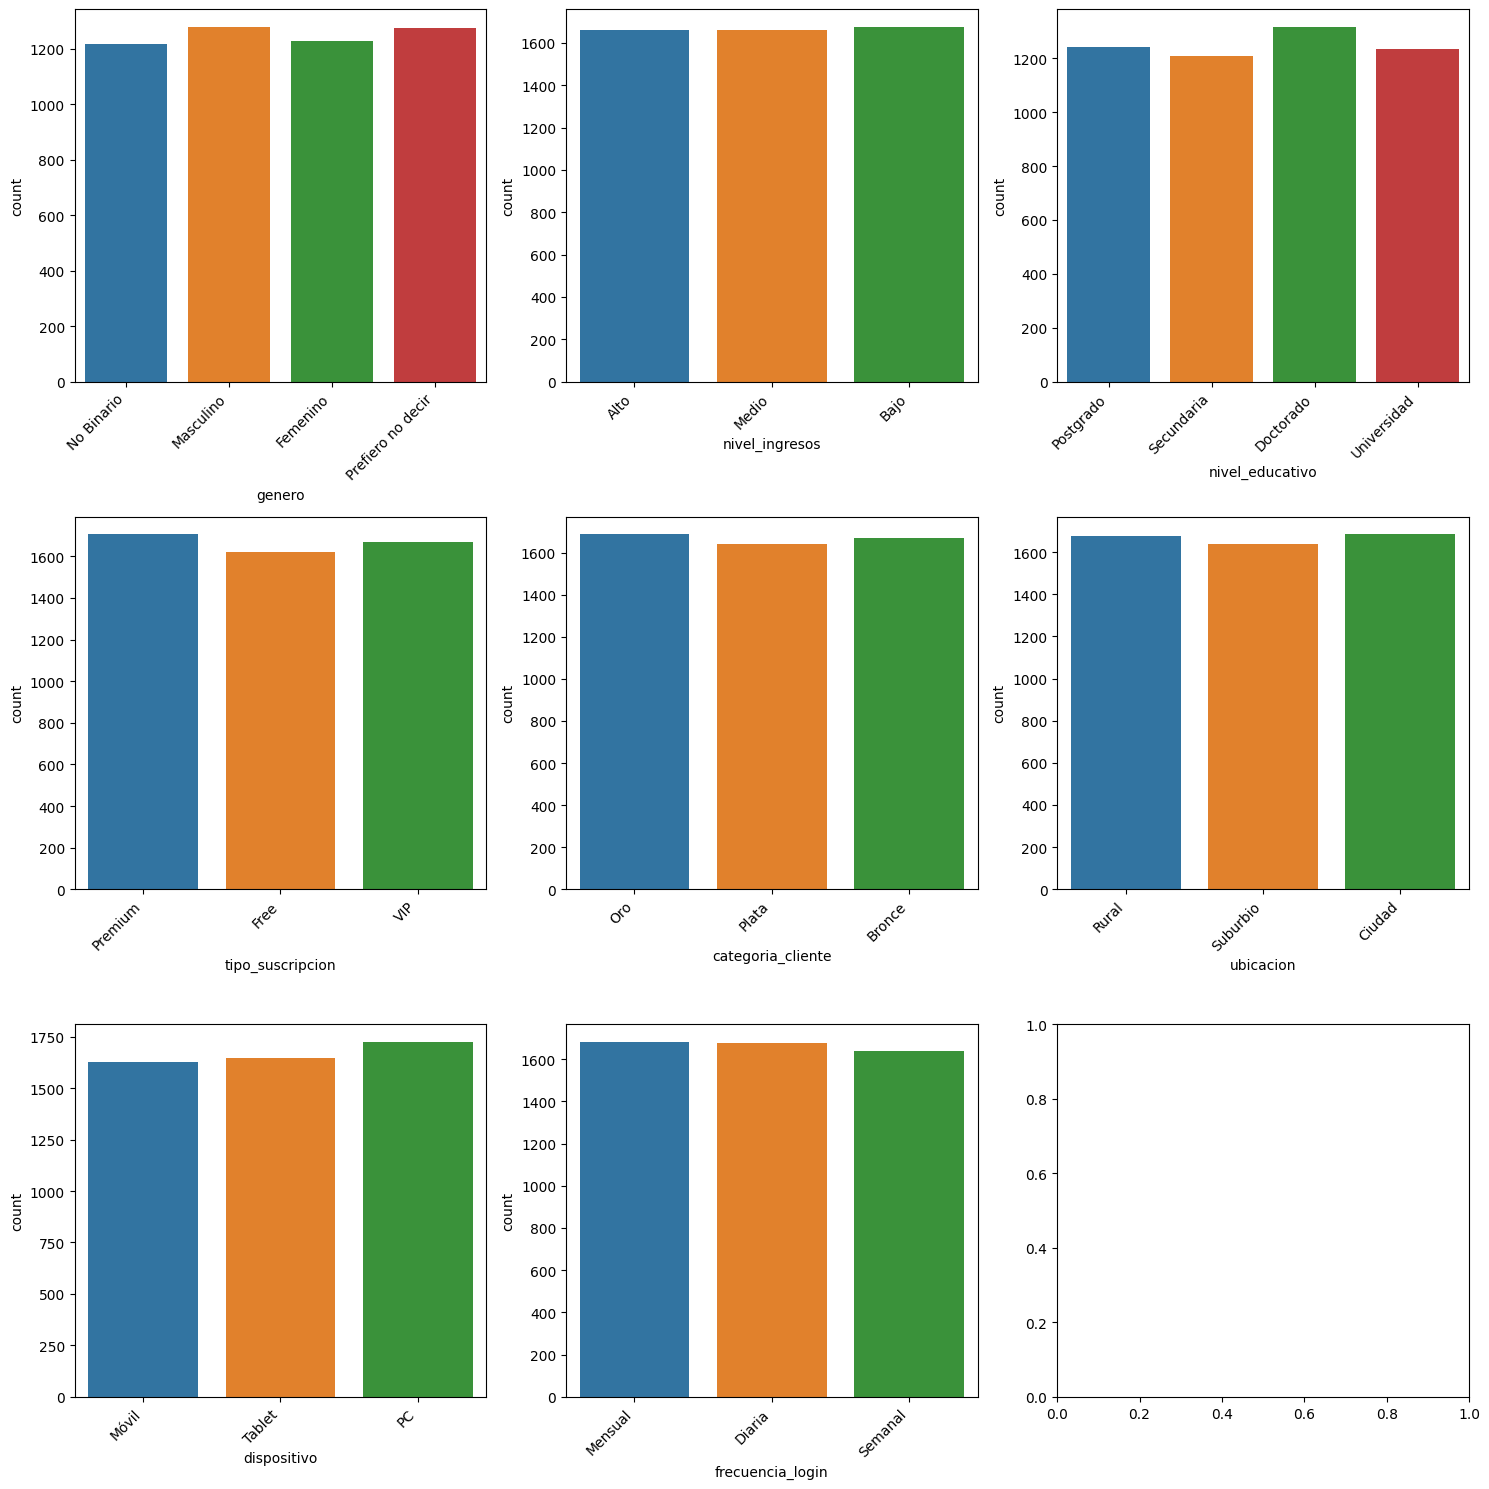

In [5]:
df_cols = users_df[['genero', 'nivel_ingresos', 'nivel_educativo', 'tipo_suscripcion', 'categoria_cliente', 'ubicacion', 'dispositivo', 'frecuencia_login']]

n=len(df_cols.columns)

fig,ax = plt.subplots(math.ceil(n / 3),3, figsize=(15,15))
ax = ax.flatten()
# Si tienes una sola columna de gráficos, usa ax en vez de ax[i]
for i, col in enumerate(df_cols.columns):
    plt.sca(ax[i])  # Seleccionar el subgráfico actual
    sns.countplot(x=col, data=df_cols)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

### Productos

In [6]:
print("El tamaño de la base de productos es:", products_df.shape)
print("Las columnas con las que cuenta es:", products_df.columns.tolist())
print("El número de ID's únicos es:", len(products_df['product_id'].unique()))

El tamaño de la base de productos es: (2000, 9)
Las columnas con las que cuenta es: ['product_id', 'name', 'category', 'descripcion', 'palabras_clave', 'precio', 'rating_promedio', 'descuento_aplicado', 'stock_actual']
El número de ID's únicos es: 2000


In [114]:
products_df.isna().sum()

product_id            0
name                  0
category              0
descripcion           0
palabras_clave        0
precio                0
rating_promedio       0
descuento_aplicado    0
stock_actual          0
dtype: int64

### Interacciones

In [8]:
print("El tamaño de la base de interactions es:", interactions_df.shape)
print("Las columnas con las que cuenta es:", interactions_df.columns.tolist())
print("El número de ID's únicos es:", len(interactions_df['user_id'].unique()))

El tamaño de la base de interactions es: (50000, 7)
Las columnas con las que cuenta es: ['user_id', 'product_id', 'tipo_interaccion', 'rating', 'comentario', 'timestamp', 'metodo_pago']
El número de ID's únicos es: 4999


In [21]:
interactions_df['user_id'].unique()

array([4915, 4608, 1695, ..., 3505, 2201, 4923], dtype=int64)

In [9]:
interactions_df.isna().sum()

user_id                 0
product_id              0
tipo_interaccion        0
rating              39676
comentario          39564
timestamp               0
metodo_pago             0
dtype: int64

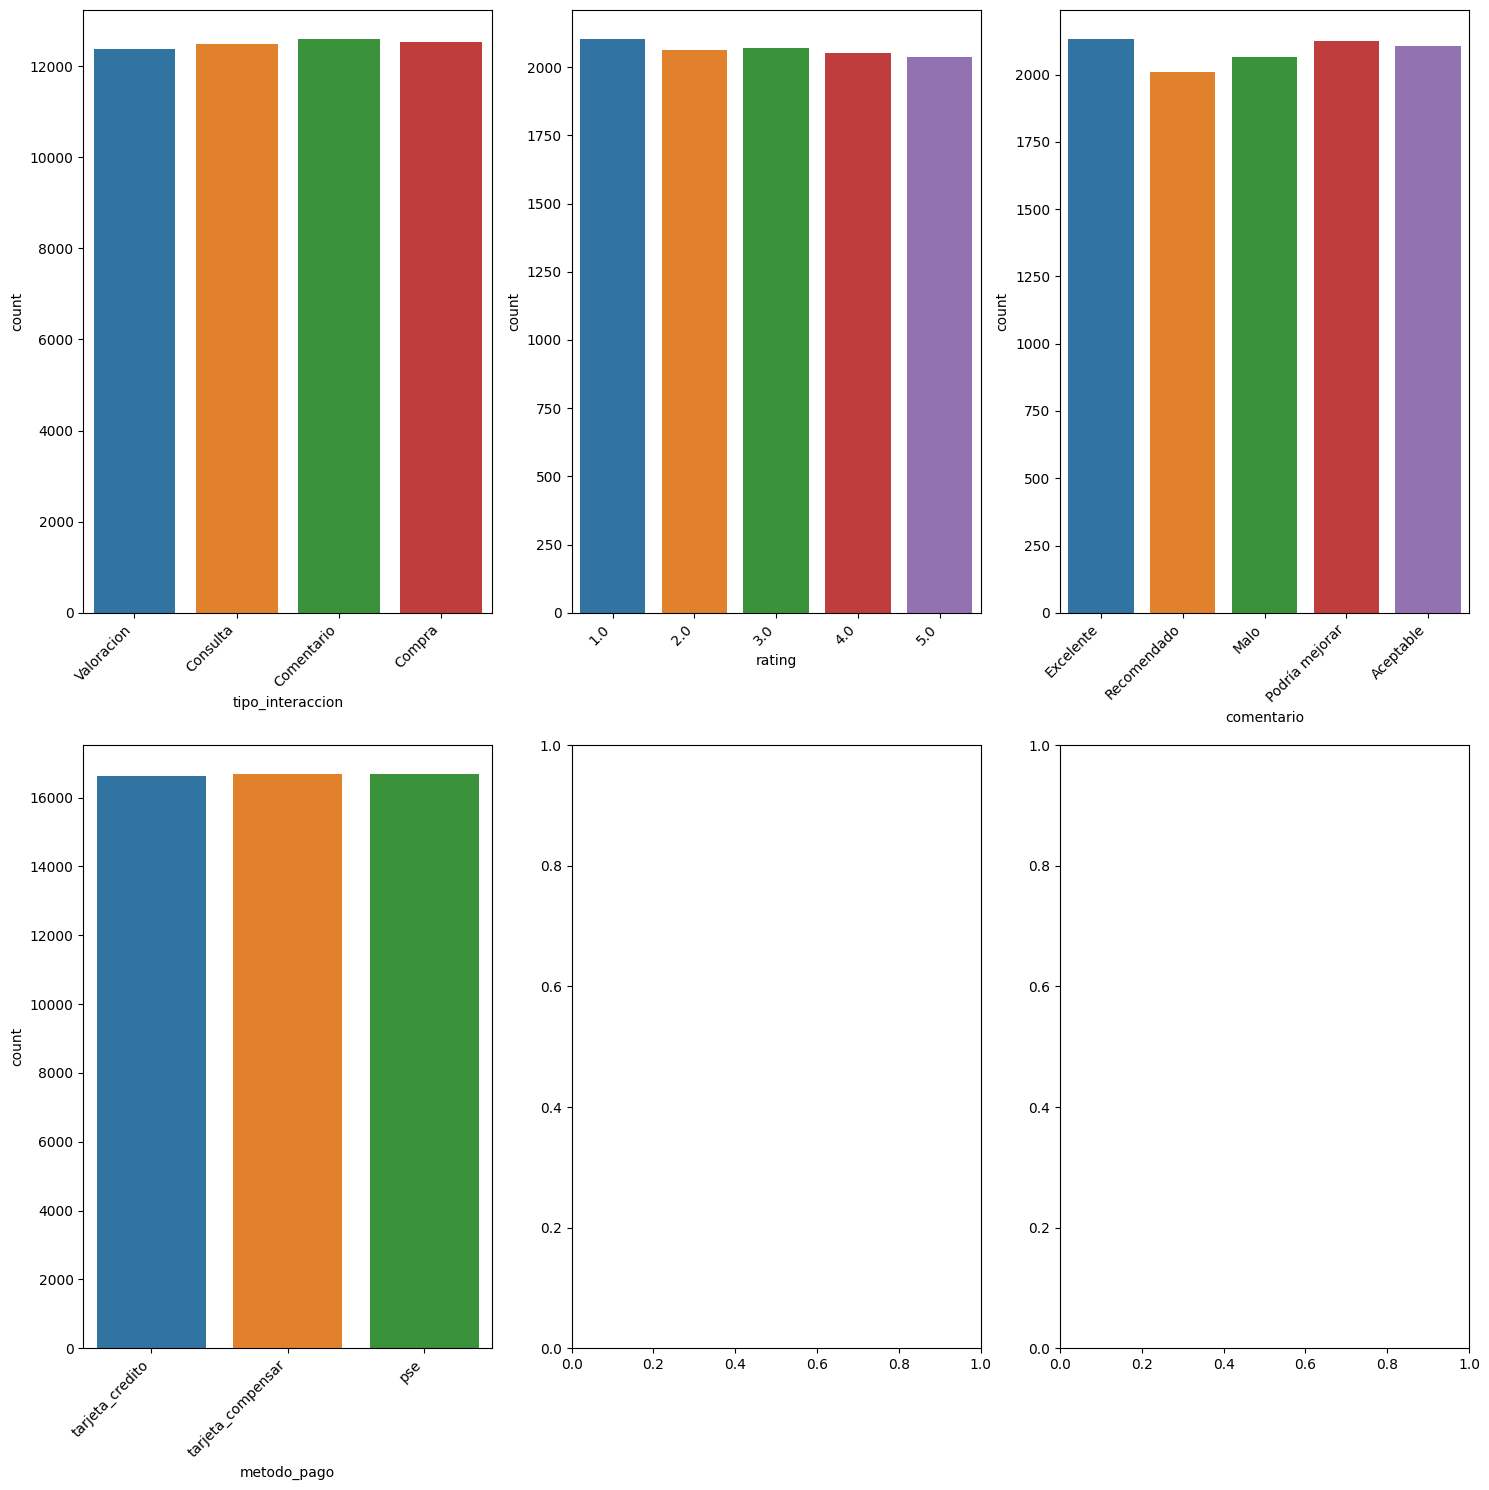

In [10]:
df_cols = interactions_df[['tipo_interaccion', 'rating', 'comentario', 'metodo_pago']]

n=len(df_cols.columns)

fig,ax = plt.subplots(math.ceil(n / 3),3, figsize=(15,15))
ax = ax.flatten()
# Si tienes una sola columna de gráficos, usa ax en vez de ax[i]
for i, col in enumerate(df_cols.columns):
    plt.sca(ax[i])  # Seleccionar el subgráfico actual
    sns.countplot(x=col, data=df_cols)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

## Modelado

In [4]:
from surprise import Dataset, Reader, SVD, KNNBasic, KNNBaseline
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV
from surprise import accuracy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

In [5]:
print("Los usuarios tienen el siguiente tipo de interacciones:",interactions_df['tipo_interaccion'].unique())
print("Los usuarios tienen el siguiente tipo de comentarios:",interactions_df['comentario'].unique())

Los usuarios tienen el siguiente tipo de interacciones: ['Valoracion' 'Consulta' 'Comentario' 'Compra']
Los usuarios tienen el siguiente tipo de comentarios: [nan 'Excelente' 'Recomendado' 'Malo' 'Podría mejorar' 'Aceptable']


Debido a que hay diferentes tipos de interacción con los productos que se ofrecen en Compensar, se procederá a crear una variable donde se genere un puntaje de afinidad del usuario con el producto, teniendo en cuenta los siguientes aspectos:
- La valoración de 5 sobre cualquier producto, debería tener el mayor valor en el nuevo índice de afinidad que se procederá a construir.
- Debido a que las interacciones son mutuamente excluyentes, los comentarios pueden ser similares a la variable de valoración (_rating_) en el sentido de las siguientes condiciones:
    * Excelente: 5
    * Recomendado: 4
    * Aceptable: 3
    * Podría mejorar: 2 
    * Malo:1 
- Comprar un producto debería tener un mayor puntaje que solo consultar, y a su vez, estas interacciones tendrán un mayor puntaje que las calificaciones malas (1,2)
- A las valoraciones y comentarios que no tienen valores, se les asignará el valor de 4, pues se supondrá que el servicio o producto fue adquirido, y recibirá el mismo puntaje que cuando se compra. 


In [6]:
# Ajuste de variables
interactions_df['comentario_num'] = interactions_df['comentario'].map({"Excelente": 5,
                                                                           "Recomendado": 4,
                                                                           "Aceptable": 3,
                                                                           "Podría mejorar": 2,
                                                                           "Malo":1})
interactions_df['compra'] = interactions_df['tipo_interaccion'].apply(lambda x: 1 if x == "Compra" else 0)
interactions_df['consulta'] = interactions_df['tipo_interaccion'].apply(lambda x: 1 if x == "Consulta" else 0)

In [7]:
# Preparar el puntaje de interacción estándar 
puntajes = {
    'rating': 1,     # El valor del puntaje valdrá lo mismo
    'compra': 4,     # Comprar tendrá una calificación similar a 4 en el rating
    'comentario': 1, # Comentar tendrá el mismo valor asignado de acuerdo a la regla definida anteriormente 
    'consulta': 3    # Buscar en la señal de interés más baja; sin embargo debe ser mayor que recibir una valoración negativa de un producto
}

interactions_df['interaction_score'] = (
    interactions_df['rating'].fillna(0) * puntajes['rating'] +
    interactions_df['compra'] * puntajes['compra'] +
    interactions_df['comentario_num'].fillna(0) * puntajes['comentario'] +
    interactions_df['consulta'] * puntajes['consulta']
)

interactions_df.loc[interactions_df['interaction_score']==0,'interaction_score'] = 4

In [76]:
interactions_df.head()

,user_id,product_id,tipo_interaccion,rating,comentario,timestamp,metodo_pago,comentario_num,compra,consulta,interaction_score
0,4915,84,Valoracion,5.0,NaN,2023-01-01 00:00:00,tarjeta_credito,NaN,0,0,5.0
1,4608,1852,Valoracion,NaN,NaN,2023-01-01 00:01:00,tarjeta_compensar,NaN,0,0,4.0
2,1695,1033,Valoracion,5.0,NaN,2023-01-01 00:02:00,tarjeta_credito,NaN,0,0,5.0
3,1781,239,Consulta,NaN,NaN,2023-01-01 00:03:00,tarjeta_compensar,NaN,0,1,3.0
4,3584,1508,Comentario,NaN,Excelente,2023-01-01 00:04:00,pse,5.0,0,0,5.0


### Filtro colaborativo

In [8]:
# Prepara la información para entrenar el modelo basado en filtro colaborativo
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(interactions_df[['user_id', 'product_id', 'interaction_score']], reader)

# Separar el df en grupos de entrenamiento y prueba
trainset, testset = train_test_split(data, test_size=0.1)

In [9]:
# CV con SVD
params = {'n_factors': [25, 50, 100],
         'reg_all': [.02, .05, .1]}
g_s_svd = GridSearchCV(SVD, param_grid=params, n_jobs=-1)
g_s_svd.fit(data)

In [10]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 1.0633757169017173, 'mae': 0.8453992524229076}
{'rmse': {'n_factors': 25, 'reg_all': 0.1}, 'mae': {'n_factors': 50, 'reg_all': 0.1}}


In [11]:
# CV con KNNBasic
knn_basic = KNNBasic(sim_options ={'name': 'pearson', 'user_based': True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

print(np.mean(cv_knn_basic['test_rmse']))

1.0322721870664928


In [12]:
# SVD: entrenamiento
svd = SVD()
svd.fit(trainset)

# SVD: predicciones
predictions = svd.test(testset)
rmse = accuracy.rmse(predictions)
print(f"Filtro colaborativo RMSE: {rmse}")

RMSE: 1.0768
Filtro colaborativo RMSE: 1.0767701411172224


In [13]:
# KNN: entrenamiento
knn = KNNBasic()
knn.fit(trainset)

# KNN: predicciones
predictions = knn.test(testset)
rmse = accuracy.rmse(predictions)
print(f"Filtro colaborativo RMSE: {rmse}")

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2493
Filtro colaborativo RMSE: 1.2493041615356972


A pesar de que en el ejercicio de cross validación el modelo de KNN presentó un mejor rendimiento, el modelo de SVD demostró un mejor resultado en el subconjunto de prueba.

### Filtro basado en contenido

In [14]:
# Preparar la información para entrenar el modelo basado en contenido
products_df['combinado'] = products_df['name'] + " " + products_df['category'] + " " + products_df['descripcion'] + " " + products_df['palabras_clave']

# Definir cojunto de stopwords en español
stopword_es = nltk.corpus.stopwords.words('spanish')

# Vectorizar
vectorizer = TfidfVectorizer(stop_words=stopword_es)
tfidf_matrix = vectorizer.fit_transform(products_df['combinado'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [32]:
type(cosine_sim)

numpy.ndarray

In [15]:
interactions_df[interactions_df['user_id']==4915]

,user_id,product_id,tipo_interaccion,rating,comentario,timestamp,metodo_pago,comentario_num,compra,consulta,interaction_score
0,4915,84,Valoracion,5.0,NaN,2023-01-01 00:00:00,tarjeta_credito,NaN,0,0,5.0
1002,4915,1198,Consulta,NaN,NaN,2023-01-01 16:42:00,tarjeta_compensar,NaN,0,1,3.0
11519,4915,331,Comentario,NaN,Recomendado,2023-01-08 23:59:00,pse,4.0,0,0,4.0
22624,4915,418,Valoracion,4.0,NaN,2023-01-16 17:04:00,tarjeta_credito,NaN,0,0,4.0
25035,4915,613,Comentario,NaN,Excelente,2023-01-18 09:15:00,tarjeta_compensar,5.0,0,0,5.0
26437,4915,1582,Consulta,NaN,NaN,2023-01-19 08:37:00,pse,NaN,0,1,3.0
27754,4915,1079,Consulta,NaN,NaN,2023-01-20 06:34:00,tarjeta_credito,NaN,0,1,3.0


### Modelo híbrido

In [16]:
# Combinar filtro colaborativo y baado en contenido
def hybrid_recommendation(user_id, top_n=5):
    all_product_ids = products_df['product_id'].values
    collaborative_scores = []

    for product_id in all_product_ids:
        prediction = svd.predict(user_id, product_id)
        collaborative_scores.append((product_id, prediction.est))
    
    collaborative_scores.sort(key=lambda x: x[1], reverse=True)
    top_collab_products = [x[0] for x in collaborative_scores[:top_n]]

    content_scores = []
    for product_id in top_collab_products:
        idx = products_df[products_df['product_id'] == product_id].index[0]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sorted_sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        content_scores.append((product_id, sorted_sim_scores[1][1]))  # Take top similar item

    content_scores.sort(key=lambda x: x[1], reverse=True)
    top_content_products = [x[0] for x in content_scores[:top_n]]

    final_recommendations = []
    for product_id in set(top_collab_products + top_content_products):
        collaborative_score = next((score for pid, score in collaborative_scores if pid == product_id), 0)
        content_score = next((score for pid, score in content_scores if pid == product_id), 0)
        final_recommendations.append((product_id, (collaborative_score + content_score) / 2))

    final_recommendations.sort(key=lambda x: x[1], reverse=True)

    return final_recommendations[:top_n]

In [61]:
# Example: Get the top 3 hybrid recommendations for user 1
user_id = 1
top_n = 5
recommendations = hybrid_recommendation(user_id, top_n)
print(f"Top {top_n} recomendaciones de productos para el usuario {user_id}:")
for product_id, score in recommendations:
    print(f"Product ID: {product_id}, Score: {score}")

Top 5 recomendaciones de productos para el usuario 1:
Product ID: 1328, Score: 2.394258963603261
Product ID: 1979, Score: 2.3789192313922953
Product ID: 1124, Score: 2.3784851191331695
Product ID: 137, Score: 2.3736628638422483
Product ID: 822, Score: 2.371854404014083


In [58]:
recomendacion_id = [x[0] for x in recommendations]

In [60]:
products_df.loc[products_df['product_id'].isin(recomendacion_id),["name","category","descripcion"]]

,name,category,descripcion
136,Reloj Inteligente para Fitness,Deportes,"Monitoriza tu ritmo cardíaco, pasos y calorías..."
821,Sesión de Terapia Online,Bienestar Mental,Consulta con expertos en bienestar mental desd...
1123,Monitor de Ritmo Cardíaco,Salud,Dispositivo preciso para medir tu frecuencia c...
1327,Rutina de Ejercicios Personalizada,Deportes,Planes de ejercicios adaptados a tus objetivos...
1978,Curso de Meditación,Bienestar Mental,Aprende técnicas de mindfulness y relajación p...


In [43]:
pd.DataFrame(recommendations).to_json()

'{"0":{"0":1328,"1":1979,"2":1124},"1":{"0":2.3942589636,"1":2.3789192314,"2":2.3784851191}}'

### Guardar resultados

In [23]:
import pickle

In [ ]:
# Guardar modelo
with open('model.pkl','wb') as f:
    pickle.dump(svd,f)

In [ ]:
# Gurdar las matriz de similitudes
np.save("Resultados/sim.npy", cosine_sim)

In [ ]:
with open('model.pkl', 'rb') as f:
    clf2 = pickle.load(f)

prueba = np.load("Resultados/sim.npy")

In [27]:
clf2.predict(1, 67)

Prediction(uid=1, iid=67, r_ui=None, est=3.5372768386603757, details={'was_impossible': False})

In [151]:
products_df[products_df['product_id'].isin([400,409,1652,67,1408,290])]

,product_id,name,category,descripcion,palabras_clave,precio,rating_promedio,descuento_aplicado,stock_actual,combinado
66,67,Reloj Inteligente para Fitness,Deportes,"Monitoriza tu ritmo cardíaco, pasos y calorías...","Fitness, Deporte, Rendimiento",115.30,4.0,10,470,Reloj Inteligente para Fitness Deportes Monito...
289,290,Clases de Yoga Online,Salud,Sesiones guiadas de yoga para mejorar la flexi...,"Bienestar, Ejercicio, Salud",143.00,3.0,25,437,Clases de Yoga Online Salud Sesiones guiadas d...
399,400,Monitor de Ritmo Cardíaco,Salud,Dispositivo preciso para medir tu frecuencia c...,"Salud, Ejercicio, Bienestar",139.71,5.0,5,297,Monitor de Ritmo Cardíaco Salud Dispositivo pr...
408,409,Spa y Masajes,Salud,Tratamientos relajantes para reducir el estrés...,"Ejercicio, Bienestar, Salud",142.56,2.5,20,6,Spa y Masajes Salud Tratamientos relajantes pa...
1407,1408,Monitor de Ritmo Cardíaco,Salud,Dispositivo preciso para medir tu frecuencia c...,"Ejercicio, Bienestar, Salud",54.74,3.0,0,282,Monitor de Ritmo Cardíaco Salud Dispositivo pr...
1651,1652,Ropa Deportiva,Deportes,Prendas cómodas y de alta calidad para mejorar...,"Rendimiento, Fitness, Deporte",47.03,2.5,15,308,Ropa Deportiva Deportes Prendas cómodas y de a...


In [147]:
products_df[products_df['product_id'].isin(interactions_df.loc[interactions_df['user_id']==4915,'product_id'].tolist())]

,product_id,name,category,descripcion,palabras_clave,precio,rating_promedio,descuento_aplicado,stock_actual,combinado
83,84,Vitaminas y Suplementos,Nutrición,Complementa tu dieta con vitaminas esenciales ...,"Suplementos, Alimentación, Dieta",22.49,3.0,10,409,Vitaminas y Suplementos Nutrición Complementa ...
330,331,Entrenamiento en Casa,Deportes,Rutinas de ejercicios para mantenerte en forma...,"Rendimiento, Fitness, Deporte",174.32,2.5,5,112,Entrenamiento en Casa Deportes Rutinas de ejer...
417,418,Rutina de Ejercicios Personalizada,Deportes,Planes de ejercicios adaptados a tus objetivos...,"Fitness, Rendimiento, Deporte",85.66,4.5,15,268,Rutina de Ejercicios Personalizada Deportes Pl...
612,613,Curso de Mindfulness,Bienestar Mental,Desarrolla hábitos de atención plena para mejo...,"Terapia, Mindfulness, Relajación",102.57,5.0,30,33,Curso de Mindfulness Bienestar Mental Desarrol...
1078,1079,Entrenador Personal Virtual,Bienestar Mental,Accede a planes de entrenamiento personalizado...,"Mindfulness, Relajación, Terapia",95.89,3.5,5,84,Entrenador Personal Virtual Bienestar Mental A...
1197,1198,Ropa Deportiva,Deportes,Prendas cómodas y de alta calidad para mejorar...,"Rendimiento, Fitness, Deporte",103.00,4.0,20,107,Ropa Deportiva Deportes Prendas cómodas y de a...
1581,1582,Ropa Deportiva,Deportes,Prendas cómodas y de alta calidad para mejorar...,"Fitness, Rendimiento, Deporte",127.74,5.0,15,400,Ropa Deportiva Deportes Prendas cómodas y de a...
